## Discretisation with Decision Trees using Feature-Engine


**Feature Engine** allows you to implement **decision tree discretisation on all your numerical variables very easily**, including search over the multiple parameters of the decision tree, to find the best one.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import DecisionTreeDiscretiser

In [2]:
data = pd.read_csv('titanic.csv', usecols = ['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

**Copy data! Random sampling! Extract the random sample to fill the na! Pandas needs to have the same index in order to merge datasets!**

In [4]:
def impute_na(data, variable):
    df = data.copy()
    df[variable+'_random'] = df[variable]
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    return df[variable+'_random']

**Replace NA in both train and test sets!**

In [5]:
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')
X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,40.5,7.7250
686,22.0,7.7250


Set up the **decision tree discretiser** indicating: **cross-validation number (cv)**! the **variables we want to discretise** whether it is a target for regression or classification
and the grid with the parameters we want to test!**

In [7]:
treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})
treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

**Inspect the tree for age!**

In [8]:
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

**And the performance obtained on the train set while fitting!**

In [9]:
treeDisc.scores_dict_['age']

0.6200873362445415

**And the best parameters for fare!**

In [10]:
treeDisc.binner_dict_['fare'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

**And the performance obtained on the train set while fitting!**

In [11]:
treeDisc.scores_dict_['fare']

0.6888646288209607

By comparing the accuracy of the decision trees for age and fare, we can derive that fare is a better indicator of the outcome survived.

**Transform the data!**

In [12]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

**Inspect how many bins we found!**

In [13]:
train_t['age'].unique()

array([0.61111111, 0.50909091, 0.39849624, 0.31481481, 0.21428571,
       0.29411765, 0.09090909])

**Monotonic relationship with target: train set!**

Text(0, 0.5, 'Survived')

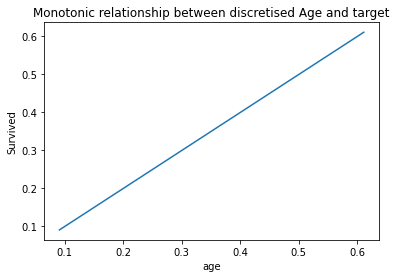

In [14]:
pd.concat([train_t, y_train], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

**Monotonic relationship with target: test set!**

Text(0, 0.5, 'Survived')

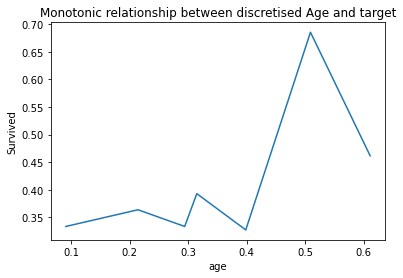

In [15]:
pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

The monotonic relationship between bins and target is not amazing. I have to say that I needed to play quite a bit with the parameters of the tree to find the optimal tree, to keep the monotonic relationship to some degree. But, it is the trade off, like from anything else in life :)

**Explore the monotonic relationship for fare!**

Text(0, 0.5, 'Survived')

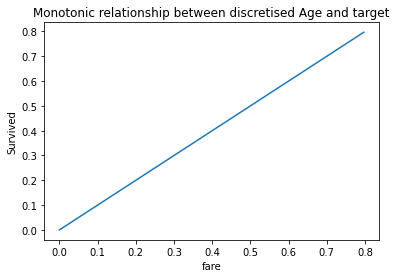

In [16]:
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

**Monotonic relationship with target: test set!**

Text(0, 0.5, 'Survived')

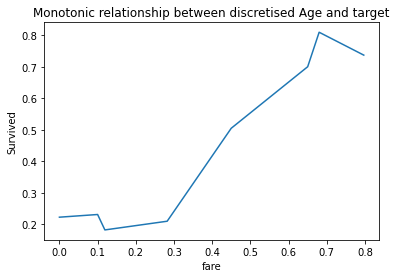

In [17]:
pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

For fare, the monotonic relationship was preserved, almost entirely, except at the edges, which suggests that the tree could be overfitting to the train set.

**Explore how many observations we have per bin!**

Text(0, 0.5, 'Number of observations per bin')

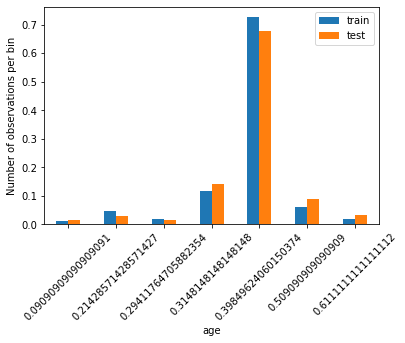

In [18]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Most of the observations are in the middle bucket, which indicates that this variable is not very predictive. 

**Explore how many observations we have per bin!**

Text(0, 0.5, 'Number of observations per bin')

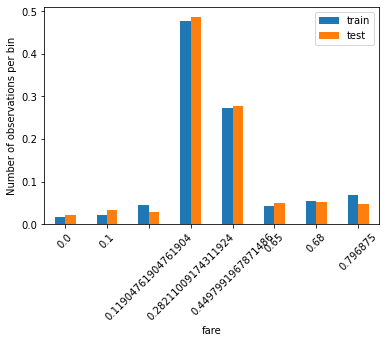

In [19]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

For fare, the tree sorted the values in more buckets, therefore creating a better value spread (remember that fare was quite skewed).